In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/mini_project

Mounted at /content/drive
/content/drive/MyDrive/mini_project


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
from IPython.display import display
import pandas as pd
import os
import pickle

In [3]:
def load_cifar10_data(batch_size=128, force_reload=False):
    """Load CIFAR-10 data with optional save/load of preprocessed data"""
    cache_path = './cifar10_data_cache.pkl'

    # If cache exists and not forced to reload
    if os.path.exists(cache_path) and not force_reload:
        with open(cache_path, 'rb') as f:
            print("Loading cached CIFAR-10 data...")
            return pickle.load(f)

    # Otherwise load from original data
    transform = Compose([
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_data = CIFAR10(root='./data', train=True, download=False, transform=transform)
    test_data = CIFAR10(root='./data', train=False, download=False, transform=transform)

    # Fix random seed for reproducible splits
    torch.manual_seed(42)
    train_size = int(0.95 * len(train_data))
    val_size = len(train_data) - train_size
    train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    # Save to cache
    data_to_cache = (train_loader, val_loader, test_loader, classes)
    with open(cache_path, 'wb') as f:
        pickle.dump(data_to_cache, f)
    print("CIFAR-10 data cached for future runs.")

    return train_loader, val_loader, test_loader, classes

In [4]:
# Load data once and share across both classifiers
train_loader, val_loader, test_loader, classes = load_cifar10_data()

Loading cached CIFAR-10 data...


In [18]:
class CIFAR10Classifier:
    def __init__(self, batch_size=128, learning_rate=0.001, alpha=0.99, weight_decay=1e-4):
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.weight_decay = weight_decay
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Tracking variables for metrics
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.gradient_norms = []
        self.learning_speed = []

        # Use the shared data loaders
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.classes = classes

        self.model = self._create_model().to(self.device)

    def _create_model(self):
        """Use ResNet18 and adapt it for CIFAR-10"""
        model = resnet18(weights=False)
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()       # Remove maxpool to suit 32x32 input
        model.fc = nn.Linear(model.fc.in_features, 10)
        return model

    def train(self, epochs=10):
        optimizer = optim.RMSprop(
            self.model.parameters(),
            lr=self.learning_rate,
            alpha=self.alpha,
            weight_decay=self.weight_decay
        )

        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            batch_grad_norms = []

            pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{epochs}")
            for batch_idx, (images, labels) in enumerate(pbar):
                images, labels = images.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()

                # Track gradient norms
                total_grad_norm = 0
                for p in self.model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_grad_norm += param_norm.item() ** 2
                total_grad_norm = total_grad_norm ** 0.5
                batch_grad_norms.append(total_grad_norm)

                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                avg_loss = running_loss / (batch_idx + 1)
                acc = correct / total
                pbar.set_postfix(loss=avg_loss, acc=acc)

            # Store gradient norms for this epoch
            self.gradient_norms.append(batch_grad_norms)

            # Calculate training metrics
            train_loss = running_loss / len(self.train_loader)
            train_acc = correct / total
            self.train_loss_history.append(train_loss)
            self.train_acc_history.append(train_acc)

            # Evaluate on validation set
            val_loss, val_acc = self.evaluate(self.val_loader)
            self.val_loss_history.append(val_loss)
            self.val_acc_history.append(val_acc)

            # Track learning speed (improvement in validation accuracy)
            if epoch > 0:
                self.learning_speed.append(val_acc - self.val_acc_history[epoch-1])
            else:
                self.learning_speed.append(0)

            print(f"Epoch {epoch+1}/{epochs} Summary: "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}")

    def evaluate(self, loader=None):
        if loader is None:
            loader = self.test_loader

        self.model.eval()
        criterion = nn.CrossEntropyLoss()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        return total_loss / len(loader), correct / total

    def get_confusion_matrix_and_report(self):
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in self.test_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        cm = confusion_matrix(all_labels, all_preds)
        report = classification_report(all_labels, all_preds, target_names=self.classes, output_dict=True)
        return cm, report

    def save_model(self, path='cifar10_resnet18.pth'):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'train_loss_history': self.train_loss_history,
            'val_loss_history': self.val_loss_history,
            'train_acc_history': self.train_acc_history,
            'val_acc_history': self.val_acc_history,
            'gradient_norms': self.gradient_norms,
            'learning_speed': self.learning_speed
        }, path)
        print(f"Model saved to {path}")

    def load_model(self, path='cifar10_resnet18.pth'):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.train_loss_history = checkpoint['train_loss_history']
        self.val_loss_history = checkpoint['val_loss_history']
        self.train_acc_history = checkpoint['train_acc_history']
        self.val_acc_history = checkpoint['val_acc_history']
        self.gradient_norms = checkpoint['gradient_norms']
        self.learning_speed = checkpoint['learning_speed']
        print(f"Model loaded from {path}")

    def plot_metrics(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        ax1.plot(self.train_loss_history, label='Train Loss')
        ax1.plot(self.val_loss_history, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Accuracy plot
        ax2.plot(self.train_acc_history, label='Train Accuracy')
        ax2.plot(self.val_acc_history, label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()

        plt.show()

        # Gradient norms plot
        plt.figure(figsize=(10, 5))
        for i, epoch_norms in enumerate(self.gradient_norms):
            plt.plot(epoch_norms, alpha=0.5, label=f'Epoch {i+1}')
        plt.title('Gradient Norms Across Batches (Each Epoch)')
        plt.xlabel('Batch')
        plt.ylabel('Gradient Norm')
        plt.legend(loc='upper left', fontsize=6)
        plt.tight_layout()
        plt.show()

        # Learning speed plot
        plt.figure(figsize=(10, 5))
        plt.plot(self.learning_speed)
        plt.title('Learning Speed (Validation Accuracy Improvement per Epoch)')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy Improvement')
        plt.show()


In [19]:
classifier = CIFAR10Classifier()
classifier.train(epochs=10)       # Train for 10 epochs

# Save the model
classifier.save_model('rmsprop_cifar10_resnet18_model.pth')

Epoch 1/10: 100%|██████████| 372/372 [00:26<00:00, 14.15it/s, acc=0.437, loss=1.55]


Epoch 1/10 Summary: Train Loss: 1.5536, Train Acc: 0.4366, Val Loss: 2.2359, Val Acc: 0.3592


Epoch 2/10: 100%|██████████| 372/372 [00:26<00:00, 14.19it/s, acc=0.632, loss=1.02]


Epoch 2/10 Summary: Train Loss: 1.0248, Train Acc: 0.6316, Val Loss: 3.7302, Val Acc: 0.1892


Epoch 3/10: 100%|██████████| 372/372 [00:26<00:00, 14.20it/s, acc=0.721, loss=0.789]


Epoch 3/10 Summary: Train Loss: 0.7887, Train Acc: 0.7207, Val Loss: 2.9615, Val Acc: 0.3776


Epoch 4/10: 100%|██████████| 372/372 [00:26<00:00, 14.19it/s, acc=0.782, loss=0.618]


Epoch 4/10 Summary: Train Loss: 0.6184, Train Acc: 0.7823, Val Loss: 2.7478, Val Acc: 0.3596


Epoch 5/10: 100%|██████████| 372/372 [00:26<00:00, 14.27it/s, acc=0.822, loss=0.507]


Epoch 5/10 Summary: Train Loss: 0.5066, Train Acc: 0.8219, Val Loss: 2.2250, Val Acc: 0.5088


Epoch 6/10: 100%|██████████| 372/372 [00:26<00:00, 14.23it/s, acc=0.855, loss=0.415]


Epoch 6/10 Summary: Train Loss: 0.4149, Train Acc: 0.8551, Val Loss: 2.8540, Val Acc: 0.4188


Epoch 7/10: 100%|██████████| 372/372 [00:26<00:00, 14.26it/s, acc=0.884, loss=0.335]


Epoch 7/10 Summary: Train Loss: 0.3355, Train Acc: 0.8838, Val Loss: 2.0606, Val Acc: 0.4736


Epoch 8/10: 100%|██████████| 372/372 [00:26<00:00, 14.26it/s, acc=0.903, loss=0.275]


Epoch 8/10 Summary: Train Loss: 0.2746, Train Acc: 0.9034, Val Loss: 1.3312, Val Acc: 0.6328


Epoch 9/10: 100%|██████████| 372/372 [00:26<00:00, 14.24it/s, acc=0.922, loss=0.222]


Epoch 9/10 Summary: Train Loss: 0.2222, Train Acc: 0.9220, Val Loss: 4.8548, Val Acc: 0.4040


Epoch 10/10: 100%|██████████| 372/372 [00:26<00:00, 14.24it/s, acc=0.937, loss=0.181]


Epoch 10/10 Summary: Train Loss: 0.1809, Train Acc: 0.9368, Val Loss: 2.3050, Val Acc: 0.5616
Model saved to rmsprop_cifar10_resnet18_model.pth


In [20]:
# # Load the model
# classifier = CIFAR10Classifier()
# classifier.load_model('rmsprop_cifar10_resnet18_model.pth')


Test Accuracy: 0.5651, Test Loss: 2.3681


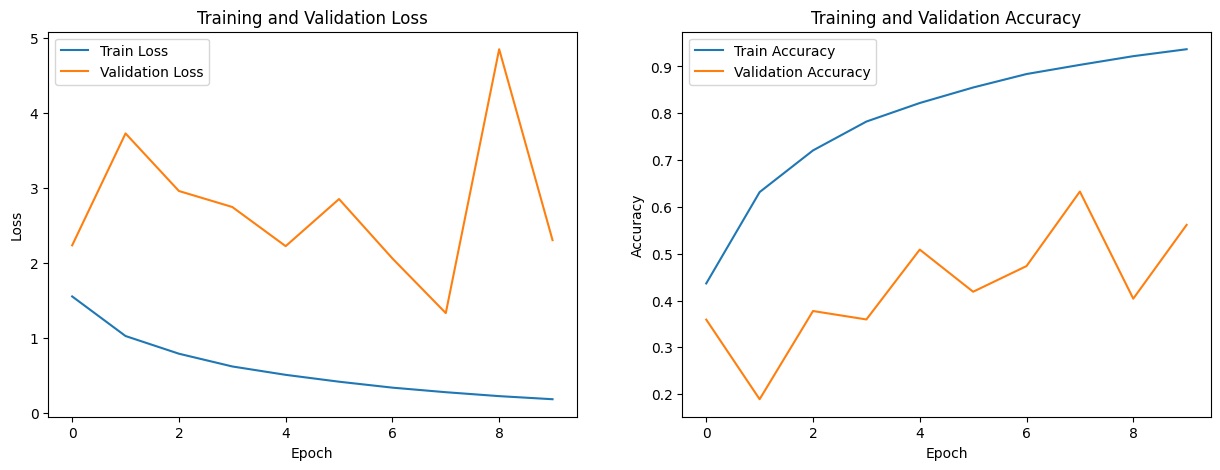

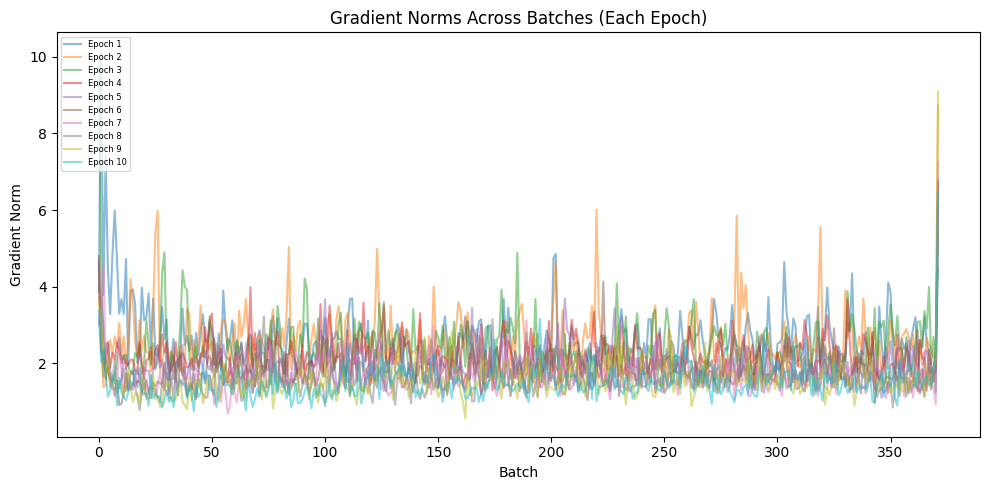

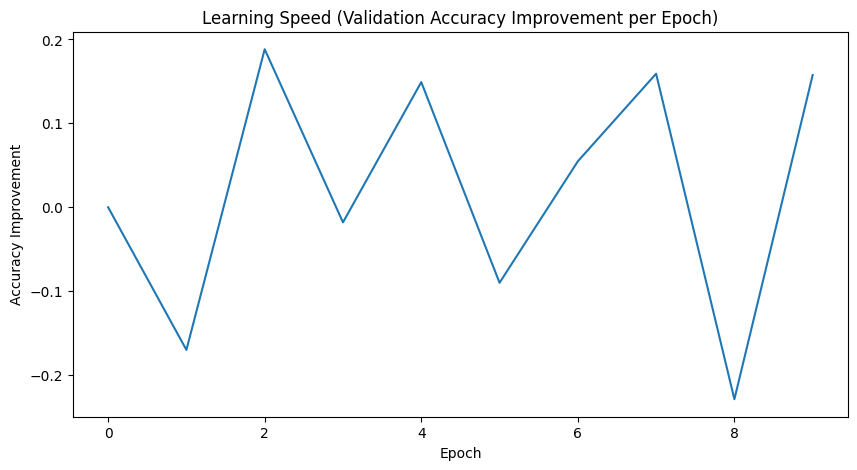

In [21]:
# Evaluate and show metrics
test_loss, test_acc = classifier.evaluate()
print(f"\nTest Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Plot training metrics
classifier.plot_metrics()

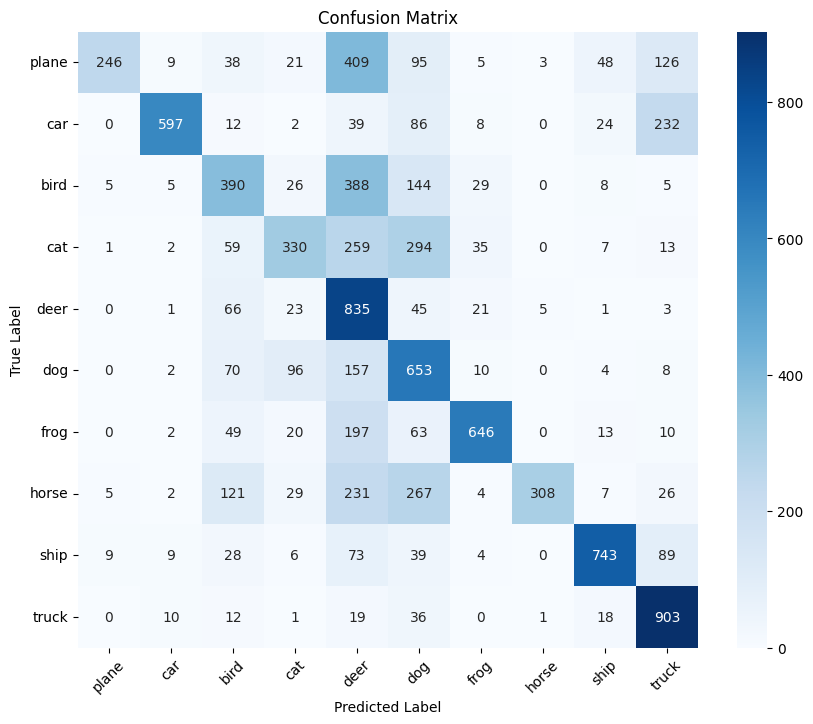

,precision,recall,f1-score,support
plane,0.924812,0.2460,0.388626,1000.0000
car,0.934272,0.5970,0.728493,1000.0000
bird,0.461538,0.3900,0.422764,1000.0000
cat,0.595668,0.3300,0.424710,1000.0000
deer,0.320292,0.8350,0.462989,1000.0000
dog,0.379210,0.6530,0.479794,1000.0000
frog,0.847769,0.6460,0.733258,1000.0000
horse,0.971609,0.3080,0.467730,1000.0000
ship,0.851088,0.7430,0.793380,1000.0000
truck,0.638163,0.9030,0.747826,1000.0000


In [22]:
# Confusion matrix and classification report
cm, report = classifier.get_confusion_matrix_and_report()
np.save("cm.npy", cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classifier.classes,
            yticklabels=classifier.classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Display classification report
report_df = pd.DataFrame(report).transpose()
display(report_df)

In [24]:
class CurriculumCIFAR10Classifier(CIFAR10Classifier):
    def __init__(self, batch_size=128, learning_rate=0.001, alpha=0.99, weight_decay=1e-4, cm=None):
        super().__init__(batch_size, learning_rate, alpha, weight_decay)
        self.class_difficulty = None  # Will be calculated based on confusion matrix
        self.current_threshold = 0.0  # Current difficulty threshold
        self.difficulty_progress = []  # Records difficulty progression
        self.epoch_samples = []  # Records number of samples used each epoch

        # Store references to the original datasets (before splitting)
        self.original_train_dataset = train_loader.dataset.dataset
        self.original_val_dataset = val_loader.dataset.dataset
        self.original_test_dataset = test_loader.dataset

        # If a confusion matrix is provided, analyse it immediately
        if cm is not None:
            self.set_confusion_matrix(cm)

    def set_confusion_matrix(self, cm: np.ndarray):
        """Inject a 10×10 confusion matrix and compute class difficulties."""
        if cm.shape != (10, 10):
            raise ValueError("`cm` must be a 10×10 NumPy array.")
        self.analyze_class_difficulty(cm)

    def analyze_class_difficulty(self, cm):
        """Calculate class difficulty based on confusion matrix"""
        class_accuracy = cm.diagonal() / cm.sum(axis=1)
        # Lower accuracy means higher difficulty
        self.class_difficulty = 1 - class_accuracy
        print("Class Difficulty Ranking:")
        for i in np.argsort(self.class_difficulty):
            print(f"{self.classes[i]}: {self.class_difficulty[i]:.3f}")

    def get_easy_samples(self, dataset, threshold):
        """Filter samples based on current difficulty threshold"""
        if self.class_difficulty is None:
            return dataset  # Use all data in initial phase

        easy_indices = []
        for idx, (_, label) in enumerate(dataset):
            if self.class_difficulty[label] <= threshold:
                easy_indices.append(idx)

        return torch.utils.data.Subset(dataset, easy_indices)

    def update_curriculum(self, epoch, total_epochs):
        """Update curriculum progression"""
        self.current_threshold = min(1.0, (epoch + 1) / total_epochs)

        max_difficulty = max(self.class_difficulty) if self.class_difficulty is not None else 1.0
        min_difficulty = min(self.class_difficulty) if self.class_difficulty is not None else 0.0

        self.current_threshold *= max_difficulty

        # effective_threshold = max(self.current_threshold, min_difficulty)

        effective_threshold = self.current_threshold + min_difficulty

        self.difficulty_progress.append(effective_threshold)
        self.current_threshold = effective_threshold

    def train(self, epochs):
        if self.class_difficulty is None:
            # Initial training (using all data)
            print("Initial training with all classes...")
            super().train(epochs=1)  # First train 1 epoch with full data

            # Analyze initial difficulty
            cm, _ = self.get_confusion_matrix_and_report()
            self.analyze_class_difficulty(cm)

        # Curriculum learning main loop
        optimizer = optim.RMSprop(
            self.model.parameters(),
            lr=self.learning_rate,
            alpha=self.alpha,
            weight_decay=self.weight_decay
        )

        criterion = nn.CrossEntropyLoss()

        # Initialize gradient norms tracking
        self.gradient_norms = []  # This will store per-epoch gradient norm statistics

        for epoch in range(epochs):
            self.update_curriculum(epoch, epochs)

            # Get data for current difficulty level from original dataset
            current_train_data = self.get_easy_samples(
                self.original_train_dataset,  # Original full dataset
                self.current_threshold
            )

            # Check if we got any samples
            if len(current_train_data) == 0:
                print(f"Warning: No samples found for threshold {self.current_threshold:.2f}, skipping epoch")
                continue

            self.epoch_samples.append(len(current_train_data))

            # Create temporary data loader for current difficulty level
            current_train_loader = DataLoader(
                current_train_data,
                batch_size=self.batch_size,
                shuffle=True
            )

            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            epoch_grad_norms = []  # Track gradient norms for this epoch

            pbar = tqdm(current_train_loader, desc=f"Epoch {epoch+1}/{epochs} (Threshold: {self.current_threshold:.2f})")
            for batch_idx, (images, labels) in enumerate(pbar):
                images, labels = images.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()

                # Calculate and store gradient norms
                total_norm = 0
                for p in self.model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = total_norm ** 0.5
                epoch_grad_norms.append(total_norm)

                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Update progress bar with additional gradient info
                avg_grad_norm = np.mean(epoch_grad_norms) if epoch_grad_norms else 0
                pbar.set_postfix(
                    loss=running_loss/(batch_idx+1),
                    acc=correct/total,
                    grad_norm=f"{avg_grad_norm:.2f}"
                )

            # Store gradient norms for this epoch
            if epoch_grad_norms:  # Only store if we have data
                self.gradient_norms.append({
                    'mean': np.mean(epoch_grad_norms),
                    'max': np.max(epoch_grad_norms),
                    'min': np.min(epoch_grad_norms),
                    'std': np.std(epoch_grad_norms),
                    'all': epoch_grad_norms  # Store all batch-wise norms
                })
            else:
                self.gradient_norms.append({
                    'mean': 0,
                    'max': 0,
                    'min': 0,
                    'std': 0,
                    'all': []
                })

            # Calculate training metrics
            train_loss = running_loss / len(current_train_loader)
            train_acc = correct / total
            self.train_loss_history.append(train_loss)
            self.train_acc_history.append(train_acc)

            # Validation (using the standard validation loader)
            val_loss, val_acc = self.evaluate(self.val_loader)
            self.val_loss_history.append(val_loss)
            self.val_acc_history.append(val_acc)

            # Track learning speed
            if epoch > 0:
                self.learning_speed.append(val_acc - self.val_acc_history[epoch-1])
            else:
                self.learning_speed.append(0)

            # Print epoch summary with gradient information
            grad_info = ""
            if epoch_grad_norms:
                grad_info = (f", Grad Norm: mean={np.mean(epoch_grad_norms):.2f} "
                            f"(±{np.std(epoch_grad_norms):.2f})")

            print(f"Epoch {epoch+1}/{epochs} Summary: "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}"
                  f"{grad_info}")

    def save_model(self, path):
        """Save the model along with curriculum learning specific parameters"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'train_loss_history': self.train_loss_history,
            'val_loss_history': self.val_loss_history,
            'train_acc_history': self.train_acc_history,
            'val_acc_history': self.val_acc_history,
            'gradient_norms': self.gradient_norms,
            'learning_speed': self.learning_speed,
            # Curriculum-specific attributes
            'class_difficulty': self.class_difficulty,
            'current_threshold': self.current_threshold,
            'difficulty_progress': self.difficulty_progress,
            'epoch_samples': self.epoch_samples,
            'batch_size': self.batch_size,
            'learning_rate': self.learning_rate,
            'alpha': self.alpha,
            'weight_decay': self.weight_decay
        }, path)
        print(f"Curriculum model saved to {path}")

    def load_model(self, path):
        """Load the model along with curriculum learning specific parameters"""
        checkpoint = torch.load(path)

        # Load base model parameters
        self.model.load_state_dict(checkpoint['model_state_dict'])

        # Load training history
        self.train_loss_history = checkpoint['train_loss_history']
        self.val_loss_history = checkpoint['val_loss_history']
        self.train_acc_history = checkpoint['train_acc_history']
        self.val_acc_history = checkpoint['val_acc_history']
        self.gradient_norms = checkpoint['gradient_norms']
        self.learning_speed = checkpoint['learning_speed']

        # Load curriculum-specific parameters
        self.class_difficulty = checkpoint['class_difficulty']
        self.current_threshold = checkpoint['current_threshold']
        self.difficulty_progress = checkpoint['difficulty_progress']
        self.epoch_samples = checkpoint['epoch_samples']
        self.batch_size = checkpoint['batch_size']
        self.learning_rate = checkpoint['learning_rate']
        self.alpha = checkpoint['alpha']
        self.weight_decay = checkpoint['weight_decay']

        print(f"Curriculum model loaded from {path}")
        print(f"current threshold: {self.current_threshold:.2f}")
        if self.class_difficulty is not None:
            print("Class Difficulty Ranking:")
            for i in np.argsort(self.class_difficulty):
                print(f"{self.classes[i]}: {self.class_difficulty[i]:.3f}")

    def plot_metrics(self):
        """Plot comprehensive training metrics"""
        # Create a 2x2 grid of plots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Loss plot (top-left)
        axs[0, 0].plot(self.train_loss_history, label='Train Loss')
        axs[0, 0].plot(self.val_loss_history, label='Validation Loss')
        axs[0, 0].set_title('Training and Validation Loss')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].set_ylabel('Loss')
        axs[0, 0].legend()

        # Accuracy plot (top-right)
        axs[0, 1].plot(self.train_acc_history, label='Train Accuracy')
        axs[0, 1].plot(self.val_acc_history, label='Validation Accuracy')
        axs[0, 1].set_title('Training and Validation Accuracy')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].set_ylabel('Accuracy')
        axs[0, 1].legend()

        # Gradient norms plot (bottom-left)
        if hasattr(self, 'gradient_norms') and len(self.gradient_norms) > 0:
            # Extract mean gradient norms for each epoch
            mean_grad_norms = [epoch_stats['mean'] for epoch_stats in self.gradient_norms]
            axs[1, 0].plot(mean_grad_norms, label='Mean Gradient Norm')
            axs[1, 0].set_title('Mean Gradient Norm Across Epochs')
            axs[1, 0].set_xlabel('Epoch')
            axs[1, 0].set_ylabel('Gradient Norm')
            axs[1, 0].legend()

        # Learning speed plot (bottom-right)
        if hasattr(self, 'learning_speed') and len(self.learning_speed) > 0:
            axs[1, 1].plot(self.learning_speed)
            axs[1, 1].set_title('Learning Speed (Validation Accuracy Improvement)')
            axs[1, 1].set_xlabel('Epoch')
            axs[1, 1].set_ylabel('Accuracy Improvement')

        plt.tight_layout()
        plt.show()

        # Additional detailed gradient plots
        if hasattr(self, 'gradient_norms') and len(self.gradient_norms) > 0:
            # Plot gradient norms per batch for each epoch
            plt.figure(figsize=(12, 6))
            for i, epoch_stats in enumerate(self.gradient_norms):
                if 'all' in epoch_stats and len(epoch_stats['all']) > 0:
                    plt.plot(epoch_stats['all'], alpha=0.5, label=f'Epoch {i+1}')
            plt.title('Gradient Norms Across Batches (Each Epoch)')
            plt.xlabel('Batch')
            plt.ylabel('Gradient Norm')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

            # Plot gradient norm distribution
            plt.figure(figsize=(12, 6))
            all_grad_norms = []
            for epoch_stats in self.gradient_norms:
                if 'all' in epoch_stats:
                    all_grad_norms.extend(epoch_stats['all'])
            if all_grad_norms:
                plt.hist(all_grad_norms, bins=50)
                plt.title('Distribution of Gradient Norms')
                plt.xlabel('Gradient Norm')
                plt.ylabel('Frequency')
                plt.show()

In [25]:
cm_loaded = np.load("cm.npy")
curriculum = CurriculumCIFAR10Classifier(
    batch_size=128,
    learning_rate=0.001,
    alpha=0.99,
    weight_decay=1e-4,
    cm=cm_loaded,                # Inject difficulty information directly
)

curriculum.train(epochs=20)      # Curriculum training loop

# Save the model
curriculum.save_model('rmsprop_cifar10_curriculum_20.pth')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Class Difficulty Ranking:
truck: 0.097
deer: 0.165
ship: 0.257
dog: 0.347
frog: 0.354
car: 0.403
bird: 0.610
cat: 0.670
horse: 0.692
plane: 0.754


Epoch 1/20 (Threshold: 0.13): 100%|██████████| 40/40 [00:02<00:00, 14.29it/s, acc=0.974, grad_norm=0.49, loss=0.0651]


Epoch 1/20 Summary: Train Loss: 0.0651, Train Acc: 0.9744, Val Loss: 11.3598, Val Acc: 0.0988, Grad Norm: mean=0.49 (±2.87)


Epoch 2/20 (Threshold: 0.17): 100%|██████████| 79/79 [00:05<00:00, 14.21it/s, acc=0.847, grad_norm=1.89, loss=0.429]


Epoch 2/20 Summary: Train Loss: 0.4289, Train Acc: 0.8472, Val Loss: 7.7124, Val Acc: 0.1588, Grad Norm: mean=1.89 (±1.99)


Epoch 3/20 (Threshold: 0.21): 100%|██████████| 79/79 [00:05<00:00, 14.30it/s, acc=0.913, grad_norm=1.19, loss=0.219]


Epoch 3/20 Summary: Train Loss: 0.2186, Train Acc: 0.9129, Val Loss: 7.6523, Val Acc: 0.1288, Grad Norm: mean=1.19 (±0.56)


Epoch 4/20 (Threshold: 0.25): 100%|██████████| 79/79 [00:05<00:00, 14.31it/s, acc=0.93, grad_norm=1.06, loss=0.184]


Epoch 4/20 Summary: Train Loss: 0.1837, Train Acc: 0.9301, Val Loss: 7.8309, Val Acc: 0.1320, Grad Norm: mean=1.06 (±0.65)


Epoch 5/20 (Threshold: 0.29): 100%|██████████| 118/118 [00:08<00:00, 14.17it/s, acc=0.807, grad_norm=2.35, loss=0.514]


Epoch 5/20 Summary: Train Loss: 0.5143, Train Acc: 0.8067, Val Loss: 8.7227, Val Acc: 0.1976, Grad Norm: mean=2.35 (±1.36)


Epoch 6/20 (Threshold: 0.32): 100%|██████████| 118/118 [00:08<00:00, 14.37it/s, acc=0.89, grad_norm=1.72, loss=0.296]


Epoch 6/20 Summary: Train Loss: 0.2962, Train Acc: 0.8901, Val Loss: 7.6025, Val Acc: 0.2124, Grad Norm: mean=1.72 (±0.80)


Epoch 7/20 (Threshold: 0.36): 100%|██████████| 196/196 [00:13<00:00, 14.21it/s, acc=0.73, grad_norm=2.39, loss=0.713]


Epoch 7/20 Summary: Train Loss: 0.7129, Train Acc: 0.7304, Val Loss: 13.1452, Val Acc: 0.3148, Grad Norm: mean=2.39 (±1.02)


Epoch 8/20 (Threshold: 0.40): 100%|██████████| 196/196 [00:13<00:00, 14.28it/s, acc=0.823, grad_norm=2.31, loss=0.473]


Epoch 8/20 Summary: Train Loss: 0.4727, Train Acc: 0.8229, Val Loss: 6.7525, Val Acc: 0.3656, Grad Norm: mean=2.31 (±0.71)


Epoch 9/20 (Threshold: 0.44): 100%|██████████| 235/235 [00:16<00:00, 14.16it/s, acc=0.808, grad_norm=2.52, loss=0.535]


Epoch 9/20 Summary: Train Loss: 0.5347, Train Acc: 0.8077, Val Loss: 6.1093, Val Acc: 0.3324, Grad Norm: mean=2.52 (±0.81)


Epoch 10/20 (Threshold: 0.47): 100%|██████████| 235/235 [00:16<00:00, 14.21it/s, acc=0.858, grad_norm=2.17, loss=0.398]


Epoch 10/20 Summary: Train Loss: 0.3980, Train Acc: 0.8583, Val Loss: 6.2443, Val Acc: 0.3968, Grad Norm: mean=2.17 (±0.77)


Epoch 11/20 (Threshold: 0.51): 100%|██████████| 235/235 [00:16<00:00, 14.24it/s, acc=0.884, grad_norm=1.84, loss=0.328]


Epoch 11/20 Summary: Train Loss: 0.3284, Train Acc: 0.8836, Val Loss: 5.4426, Val Acc: 0.5036, Grad Norm: mean=1.84 (±0.58)


Epoch 12/20 (Threshold: 0.55): 100%|██████████| 235/235 [00:16<00:00, 14.25it/s, acc=0.902, grad_norm=1.80, loss=0.274]


Epoch 12/20 Summary: Train Loss: 0.2743, Train Acc: 0.9018, Val Loss: 4.6070, Val Acc: 0.5244, Grad Norm: mean=1.80 (±0.57)


Epoch 13/20 (Threshold: 0.59): 100%|██████████| 235/235 [00:16<00:00, 14.23it/s, acc=0.92, grad_norm=1.61, loss=0.231]


Epoch 13/20 Summary: Train Loss: 0.2313, Train Acc: 0.9196, Val Loss: 6.0888, Val Acc: 0.4916, Grad Norm: mean=1.61 (±0.44)


Epoch 14/20 (Threshold: 0.62): 100%|██████████| 274/274 [00:19<00:00, 14.20it/s, acc=0.862, grad_norm=1.74, loss=0.384]


Epoch 14/20 Summary: Train Loss: 0.3835, Train Acc: 0.8625, Val Loss: 3.7573, Val Acc: 0.5728, Grad Norm: mean=1.74 (±0.44)


Epoch 15/20 (Threshold: 0.66): 100%|██████████| 274/274 [00:19<00:00, 14.22it/s, acc=0.897, grad_norm=1.64, loss=0.288]


Epoch 15/20 Summary: Train Loss: 0.2877, Train Acc: 0.8967, Val Loss: 4.5468, Val Acc: 0.5952, Grad Norm: mean=1.64 (±0.42)


Epoch 16/20 (Threshold: 0.70): 100%|██████████| 352/352 [00:24<00:00, 14.22it/s, acc=0.814, grad_norm=1.73, loss=0.532]


Epoch 16/20 Summary: Train Loss: 0.5317, Train Acc: 0.8141, Val Loss: 1.4914, Val Acc: 0.7492, Grad Norm: mean=1.73 (±0.40)


Epoch 17/20 (Threshold: 0.74): 100%|██████████| 352/352 [00:24<00:00, 14.23it/s, acc=0.863, grad_norm=1.71, loss=0.38]


Epoch 17/20 Summary: Train Loss: 0.3804, Train Acc: 0.8628, Val Loss: 1.4271, Val Acc: 0.7732, Grad Norm: mean=1.71 (±0.36)


Epoch 18/20 (Threshold: 0.78): 100%|██████████| 391/391 [00:27<00:00, 14.22it/s, acc=0.863, grad_norm=1.71, loss=0.395]


Epoch 18/20 Summary: Train Loss: 0.3950, Train Acc: 0.8626, Val Loss: 0.3344, Val Acc: 0.8828, Grad Norm: mean=1.71 (±0.33)


Epoch 19/20 (Threshold: 0.81): 100%|██████████| 391/391 [00:27<00:00, 14.24it/s, acc=0.895, grad_norm=1.70, loss=0.295]


Epoch 19/20 Summary: Train Loss: 0.2955, Train Acc: 0.8948, Val Loss: 0.3670, Val Acc: 0.8672, Grad Norm: mean=1.70 (±0.34)


Epoch 20/20 (Threshold: 0.85): 100%|██████████| 391/391 [00:27<00:00, 14.20it/s, acc=0.919, grad_norm=1.67, loss=0.231]


Epoch 20/20 Summary: Train Loss: 0.2314, Train Acc: 0.9188, Val Loss: 0.2730, Val Acc: 0.8976, Grad Norm: mean=1.67 (±0.40)
Curriculum model saved to rmsprop_cifar10_curriculum_20.pth


In [26]:
# # Load the model
# curriculum = CurriculumCIFAR10Classifier(
#     batch_size=128,
#     learning_rate=0.001,
#     alpha=0.99,
#     weight_decay=1e-4,
# )
# curriculum.load_model('rmsprop_cifar10_curriculum_20.pth')


Test Accuracy: 0.7803, Test Loss: 0.7123


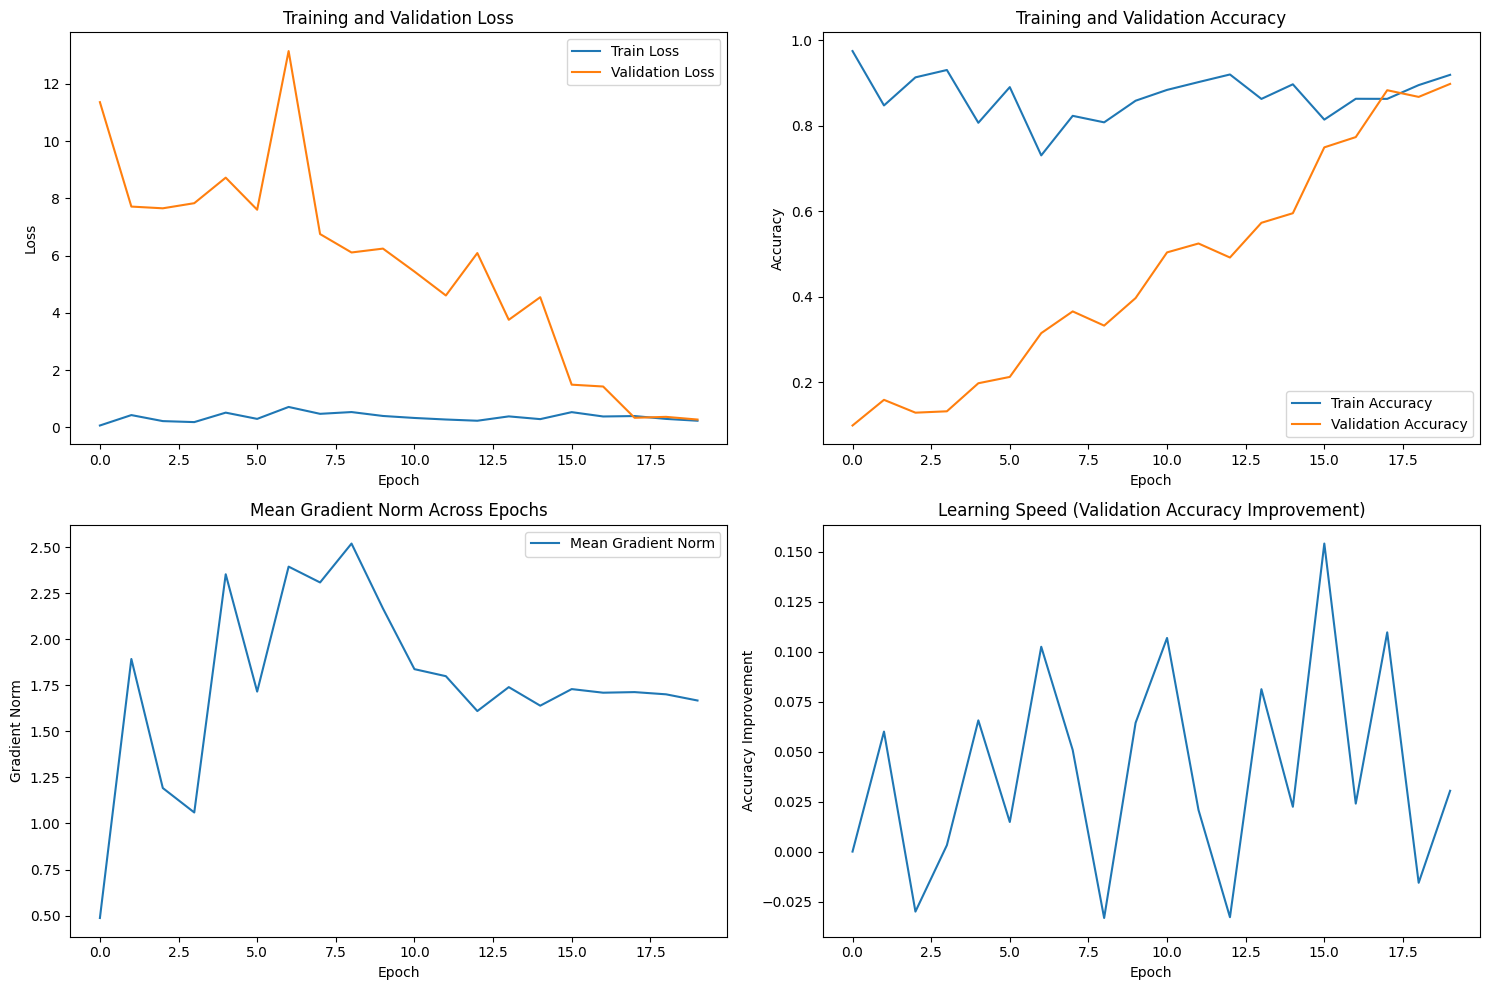

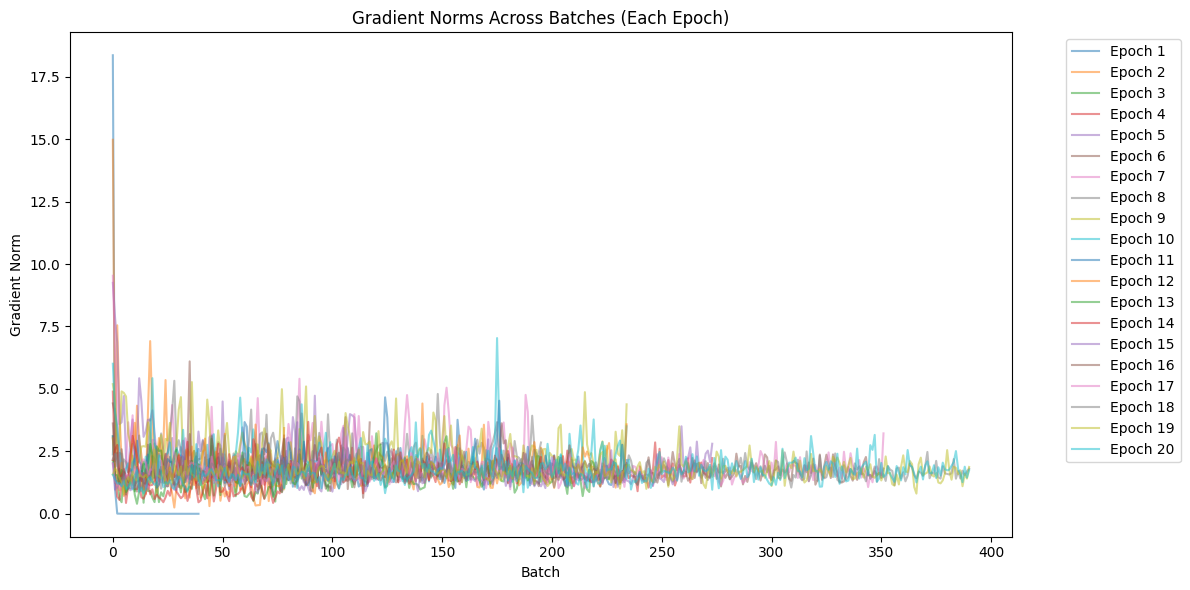

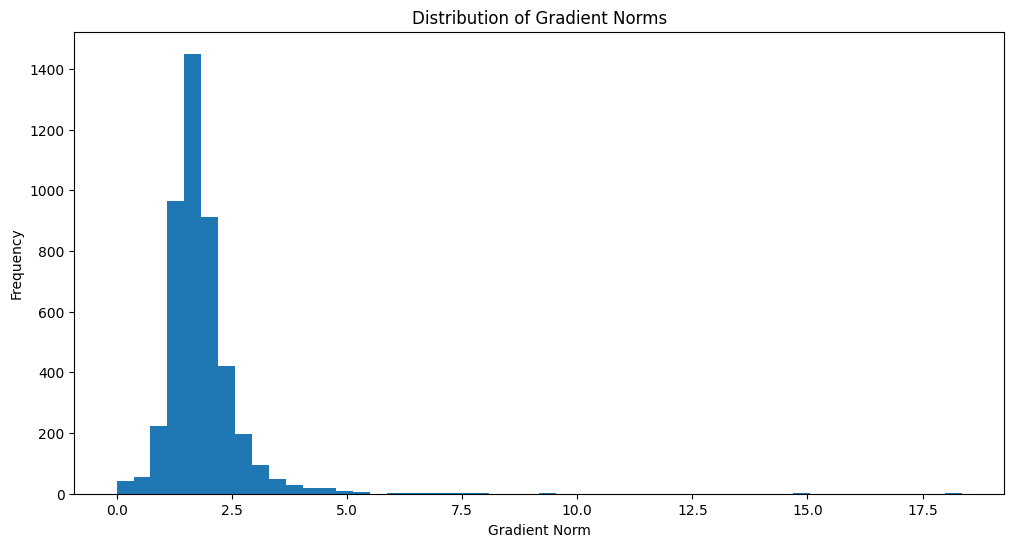

In [27]:
# Evaluate and show metrics
test_loss, test_acc = curriculum.evaluate()
print(f"\nTest Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Plot training metrics
curriculum.plot_metrics()

In [28]:
class AntiCurriculumCIFAR10Classifier(CurriculumCIFAR10Classifier):
    def update_curriculum(self, epoch, total_epochs):
        progress = min(1.0, (epoch + 1) / total_epochs)

        max_difficulty = max(self.class_difficulty) if self.class_difficulty is not None else 1.0
        min_difficulty = min(self.class_difficulty) if self.class_difficulty is not None else 0.0

        self.current_threshold = max_difficulty - progress * (max_difficulty - min_difficulty) - min_difficulty
        self.difficulty_progress.append(self.current_threshold)

    def get_easy_samples(self, dataset, threshold):
        if self.class_difficulty is None:
            return dataset

        hard_indices = []
        for idx, (_, label) in enumerate(dataset):
            if self.class_difficulty[label] >= threshold:
                hard_indices.append(idx)
        return torch.utils.data.Subset(dataset, hard_indices)

In [29]:
anticurriculum = AntiCurriculumCIFAR10Classifier(
    batch_size=128,
    learning_rate=0.001,
    alpha=0.99,
    weight_decay=1e-4,
    cm=cm_loaded,
)

anticurriculum.train(epochs=20)

# Save the model
curriculum.save_model('rmsprop_cifar10_anticurriculum_20.pth')

Class Difficulty Ranking:
truck: 0.097
deer: 0.165
ship: 0.257
dog: 0.347
frog: 0.354
car: 0.403
bird: 0.610
cat: 0.670
horse: 0.692
plane: 0.754


Epoch 1/20 (Threshold: 0.62): 100%|██████████| 118/118 [00:08<00:00, 14.19it/s, acc=0.692, grad_norm=1.78, loss=0.716]


Epoch 1/20 Summary: Train Loss: 0.7165, Train Acc: 0.6925, Val Loss: 6.6241, Val Acc: 0.1540, Grad Norm: mean=1.78 (±1.60)


Epoch 2/20 (Threshold: 0.59): 100%|██████████| 157/157 [00:11<00:00, 14.11it/s, acc=0.687, grad_norm=2.04, loss=0.811]


Epoch 2/20 Summary: Train Loss: 0.8108, Train Acc: 0.6869, Val Loss: 6.7377, Val Acc: 0.2588, Grad Norm: mean=2.04 (±1.09)


Epoch 3/20 (Threshold: 0.56): 100%|██████████| 157/157 [00:11<00:00, 14.19it/s, acc=0.743, grad_norm=1.76, loss=0.66]


Epoch 3/20 Summary: Train Loss: 0.6598, Train Acc: 0.7425, Val Loss: 7.4816, Val Acc: 0.2476, Grad Norm: mean=1.76 (±0.76)


Epoch 4/20 (Threshold: 0.53): 100%|██████████| 157/157 [00:11<00:00, 14.20it/s, acc=0.782, grad_norm=1.60, loss=0.569]


Epoch 4/20 Summary: Train Loss: 0.5686, Train Acc: 0.7821, Val Loss: 8.8060, Val Acc: 0.2948, Grad Norm: mean=1.60 (±0.66)


Epoch 5/20 (Threshold: 0.49): 100%|██████████| 157/157 [00:11<00:00, 14.25it/s, acc=0.821, grad_norm=1.50, loss=0.482]


Epoch 5/20 Summary: Train Loss: 0.4823, Train Acc: 0.8214, Val Loss: 8.8084, Val Acc: 0.2552, Grad Norm: mean=1.50 (±0.50)


Epoch 6/20 (Threshold: 0.46): 100%|██████████| 157/157 [00:11<00:00, 14.20it/s, acc=0.846, grad_norm=1.43, loss=0.413]


Epoch 6/20 Summary: Train Loss: 0.4130, Train Acc: 0.8455, Val Loss: 17.0721, Val Acc: 0.3056, Grad Norm: mean=1.43 (±0.40)


Epoch 7/20 (Threshold: 0.43): 100%|██████████| 157/157 [00:11<00:00, 14.21it/s, acc=0.873, grad_norm=1.33, loss=0.34]


Epoch 7/20 Summary: Train Loss: 0.3395, Train Acc: 0.8734, Val Loss: 8.4725, Val Acc: 0.3432, Grad Norm: mean=1.33 (±0.31)


Epoch 8/20 (Threshold: 0.39): 100%|██████████| 196/196 [00:13<00:00, 14.18it/s, acc=0.866, grad_norm=1.52, loss=0.398]


Epoch 8/20 Summary: Train Loss: 0.3980, Train Acc: 0.8656, Val Loss: 6.8673, Val Acc: 0.4196, Grad Norm: mean=1.52 (±0.50)


Epoch 9/20 (Threshold: 0.36): 100%|██████████| 196/196 [00:13<00:00, 14.19it/s, acc=0.908, grad_norm=1.30, loss=0.258]


Epoch 9/20 Summary: Train Loss: 0.2579, Train Acc: 0.9083, Val Loss: 7.2152, Val Acc: 0.4012, Grad Norm: mean=1.30 (±0.33)


Epoch 10/20 (Threshold: 0.33): 100%|██████████| 274/274 [00:19<00:00, 14.19it/s, acc=0.791, grad_norm=1.55, loss=0.579]


Epoch 10/20 Summary: Train Loss: 0.5790, Train Acc: 0.7908, Val Loss: 5.9981, Val Acc: 0.5608, Grad Norm: mean=1.55 (±0.57)


Epoch 11/20 (Threshold: 0.30): 100%|██████████| 274/274 [00:19<00:00, 14.17it/s, acc=0.853, grad_norm=1.41, loss=0.402]


Epoch 11/20 Summary: Train Loss: 0.4017, Train Acc: 0.8529, Val Loss: 5.2562, Val Acc: 0.5188, Grad Norm: mean=1.41 (±0.26)


Epoch 12/20 (Threshold: 0.26): 100%|██████████| 274/274 [00:19<00:00, 14.23it/s, acc=0.883, grad_norm=1.39, loss=0.324]


Epoch 12/20 Summary: Train Loss: 0.3238, Train Acc: 0.8827, Val Loss: 3.6165, Val Acc: 0.6184, Grad Norm: mean=1.39 (±0.29)


Epoch 13/20 (Threshold: 0.23): 100%|██████████| 313/313 [00:22<00:00, 14.13it/s, acc=0.875, grad_norm=1.47, loss=0.358]


Epoch 13/20 Summary: Train Loss: 0.3580, Train Acc: 0.8748, Val Loss: 2.8310, Val Acc: 0.6524, Grad Norm: mean=1.47 (±0.31)


Epoch 14/20 (Threshold: 0.20): 100%|██████████| 313/313 [00:21<00:00, 14.23it/s, acc=0.912, grad_norm=1.41, loss=0.245]


Epoch 14/20 Summary: Train Loss: 0.2453, Train Acc: 0.9118, Val Loss: 2.7838, Val Acc: 0.7256, Grad Norm: mean=1.41 (±0.28)


Epoch 15/20 (Threshold: 0.16): 100%|██████████| 352/352 [00:24<00:00, 14.19it/s, acc=0.885, grad_norm=1.49, loss=0.339]


Epoch 15/20 Summary: Train Loss: 0.3387, Train Acc: 0.8850, Val Loss: 1.9815, Val Acc: 0.7656, Grad Norm: mean=1.49 (±0.27)


Epoch 16/20 (Threshold: 0.13): 100%|██████████| 352/352 [00:24<00:00, 14.22it/s, acc=0.921, grad_norm=1.45, loss=0.224]


Epoch 16/20 Summary: Train Loss: 0.2237, Train Acc: 0.9213, Val Loss: 1.4971, Val Acc: 0.8484, Grad Norm: mean=1.45 (±0.31)


Epoch 17/20 (Threshold: 0.10): 100%|██████████| 352/352 [00:24<00:00, 14.23it/s, acc=0.94, grad_norm=1.40, loss=0.173]


Epoch 17/20 Summary: Train Loss: 0.1726, Train Acc: 0.9405, Val Loss: 1.4508, Val Acc: 0.8492, Grad Norm: mean=1.40 (±0.32)


Epoch 18/20 (Threshold: 0.07): 100%|██████████| 391/391 [00:27<00:00, 14.20it/s, acc=0.923, grad_norm=1.50, loss=0.229]


Epoch 18/20 Summary: Train Loss: 0.2294, Train Acc: 0.9229, Val Loss: 0.4556, Val Acc: 0.8680, Grad Norm: mean=1.50 (±0.30)


Epoch 19/20 (Threshold: 0.03): 100%|██████████| 391/391 [00:27<00:00, 14.19it/s, acc=0.946, grad_norm=1.36, loss=0.155]


Epoch 19/20 Summary: Train Loss: 0.1549, Train Acc: 0.9459, Val Loss: 0.4141, Val Acc: 0.8700, Grad Norm: mean=1.36 (±0.35)


Epoch 20/20 (Threshold: 0.00): 100%|██████████| 391/391 [00:27<00:00, 14.15it/s, acc=0.953, grad_norm=1.35, loss=0.135]


Epoch 20/20 Summary: Train Loss: 0.1353, Train Acc: 0.9535, Val Loss: 0.1098, Val Acc: 0.9616, Grad Norm: mean=1.35 (±0.35)
Curriculum model saved to rmsprop_cifar10_anticurriculum_20.pth


In [30]:
# # Load the model
# anticurriculum = AntiCurriculumCIFAR10Classifier(
#     batch_size=128,
#     learning_rate=0.001,
#     alpha=0.99,
#     weight_decay=1e-4,
# )
# curriculum.load_model('rmsprop_cifar10_anticurriculum_20.pth')


Test Accuracy: 0.8177, Test Loss: 0.6992


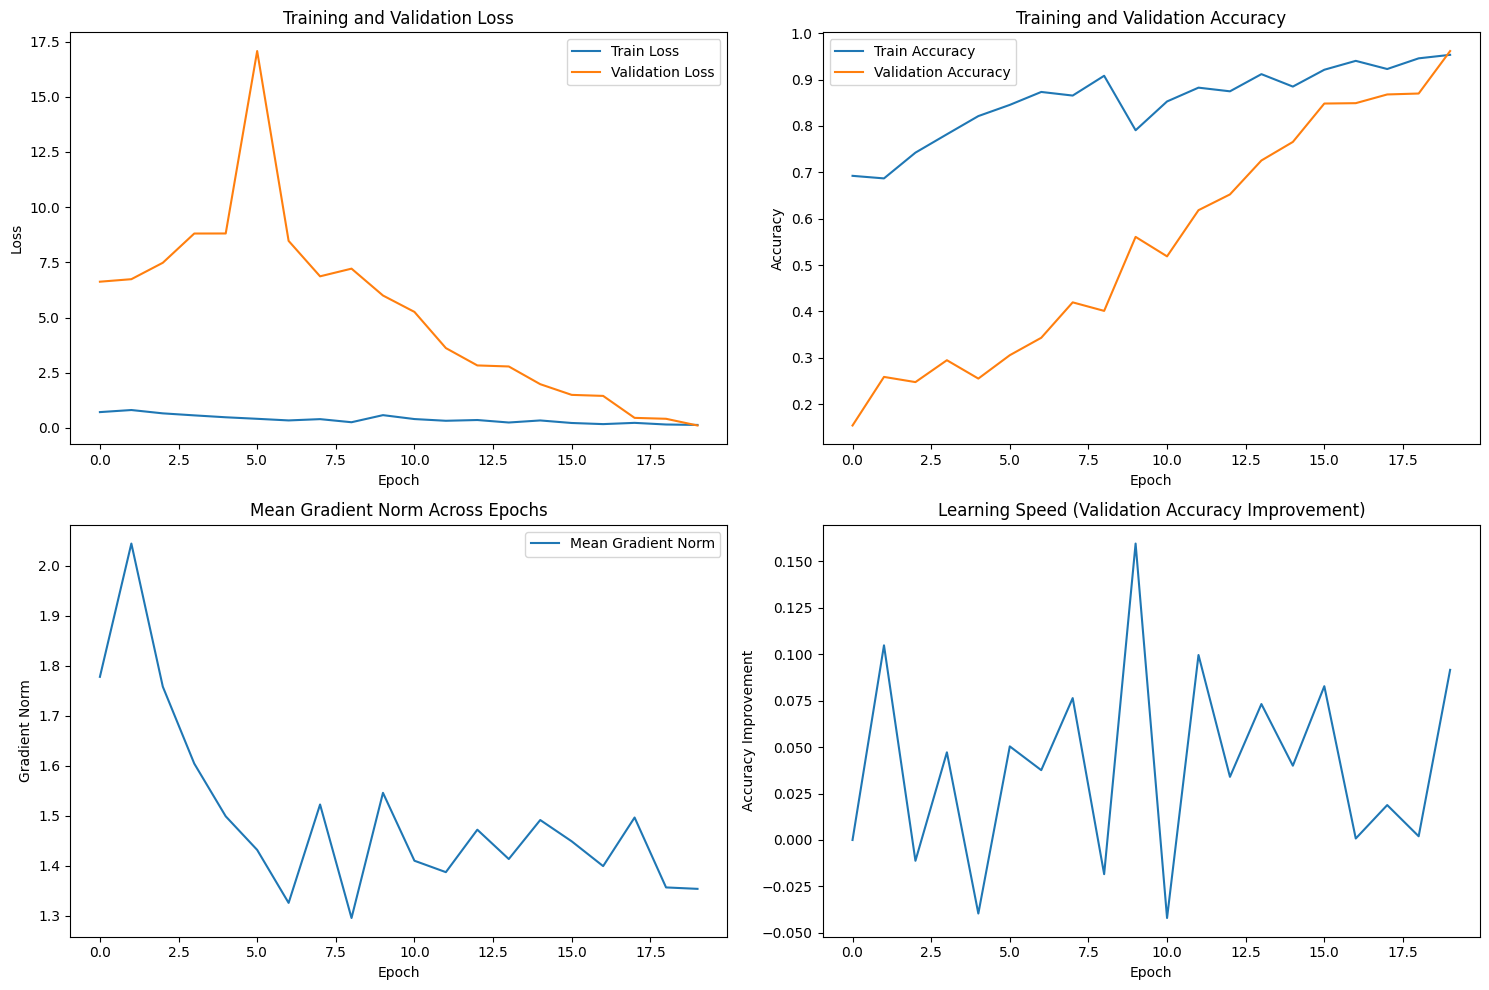

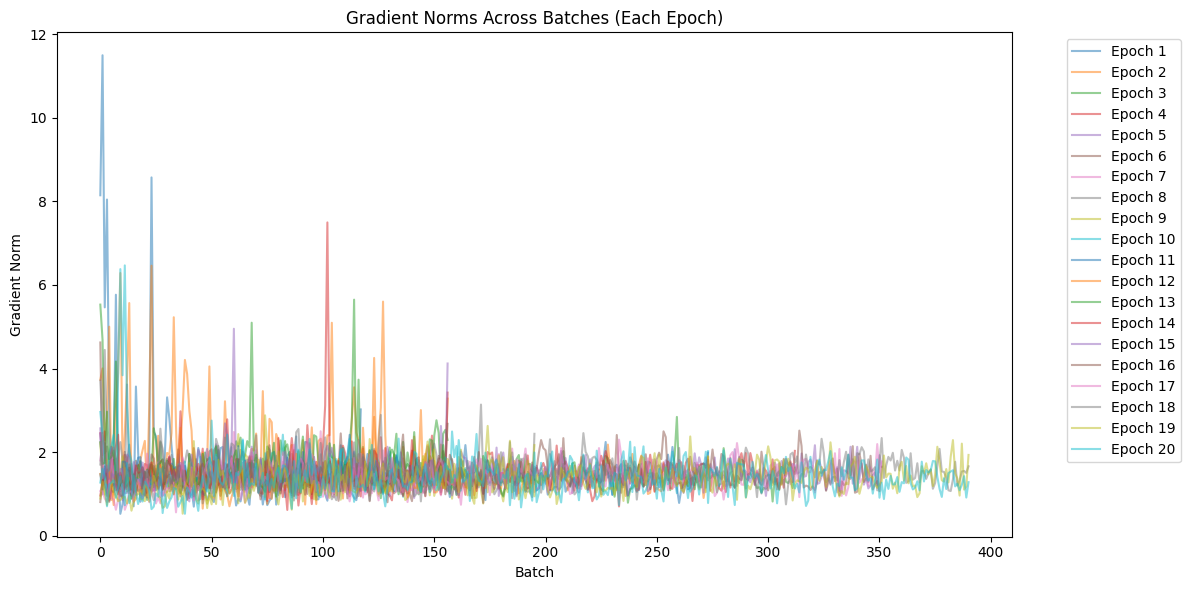

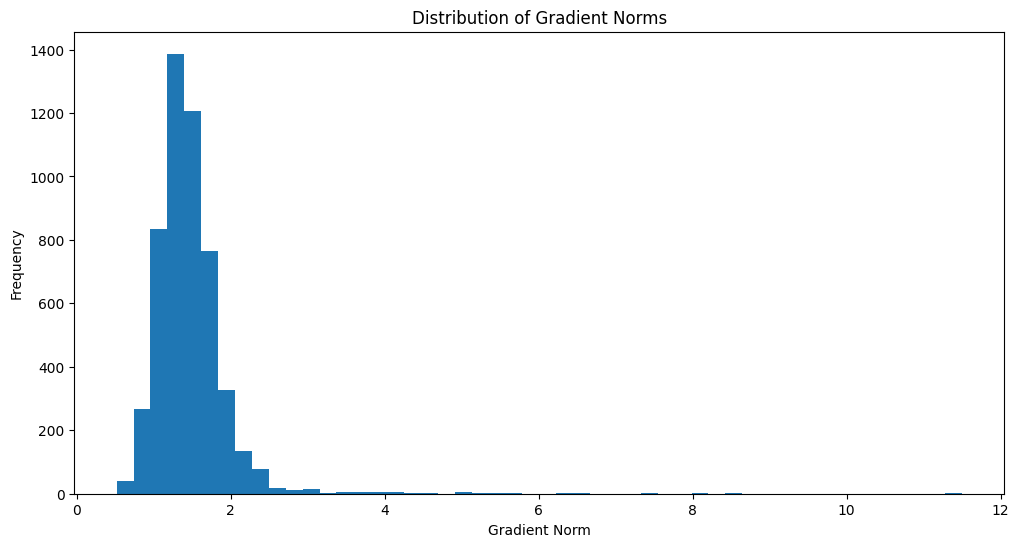

In [31]:
# Evaluate and show metrics
test_loss, test_acc = anticurriculum.evaluate()
print(f"\nTest Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Plot training metrics
anticurriculum.plot_metrics()